<a href="https://colab.research.google.com/github/martin-fabbri/tpu-workflow/blob/main/notebooks/tpu_workflow_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone https://github.com/martin-fabbri/tpu-workflow.git

In [2]:
%cd /content/tpu-workflow/

/content/tpu-workflow


In [3]:
%%capture
!pip install --upgrade --pre dvc

In [4]:
!pip list | grep "dvc\|tensorflow"

dvc                           2.0.0a2       
tensorflow                    2.4.1         
tensorflow-datasets           4.0.1         
tensorflow-estimator          2.4.0         
tensorflow-gcs-config         2.4.0         
tensorflow-hub                0.11.0        
tensorflow-metadata           0.27.0        
tensorflow-probability        0.12.1        


In [41]:
!dvc pull -r origin

Everything is up to date.


In [44]:
#!dvc repro

ERROR: failed to reproduce 'dvc.yaml': Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started


In [43]:
!pwd

/content/tpu-workflow


In [13]:
import os
import sys
from pathlib import Path

path = Path(os.getcwd())
src_path = str(path/"src")
sys.path.append(src_path)
sys.path
path

PosixPath('/content/tpu-workflow')

In [14]:
import json

import numpy as np
import tensorflow as tf
import yaml
from matplotlib import pyplot as plt
from models.xception_ft_model import create_xception_ft_model
from pipeline.train_utils import (
    MapDict,
    get_training_dataset,
    get_validation_dataset,
    load_dataset,
    lrfn,
    to_float32,
)
from tensorflow.keras.callbacks import LearningRateScheduler

print("tensorflow", tf.__version__)

tensorflow 2.4.1


In [15]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()
print("Number of accelerators", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.61.43.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.43.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators 8


## Load config

In [16]:
params_path = str(path/"params.yaml")

with open(params_path, "r") as params_file:
    params = yaml.load(params_file)
dataset_config = MapDict(params["dataset"])
split_config = MapDict(params["split"])
train_config = MapDict(params["train"])
train_config.batch_size *= strategy.num_replicas_in_sync
lr_config = MapDict(params["train"]["lr"])
lr_config.max *= strategy.num_replicas_in_sync
print("dataset:\n\n", dataset_config)
print()
print("split:\n\n", split_config)
print()
print("train:\n\n", train_config)
print()
print("lr:\n\n", lr_config)

dataset:

 {'image_size': 331, 'gcs_path': 'gs://kaggle-data-tpu/images', 'gcs_path_remote_alias': 'gcs_images', 'classes': ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']}

split:

 {'train_split_path': 'data/interim/train_split.json', 'val_split_path': 'data/interim/val_split.json', 'images_count_path': 'data/interim/images_count.json', 'validation_split': 0.19}

train:

 {'nb_validation_samples': 800, 'epochs': 12, 'batch_size': 128, 'lr': {'start': 1e-05, 'max': 5e-05, 'min': 1e-05, 'rampup_epochs': 5, 'sustain_epochs': 0, 'exp_decay': 0.8}}

lr:

 {'start': 1e-05, 'max': 0.0004, 'min': 1e-05, 'rampup_epochs': 5, 'sustain_epochs': 0, 'exp_decay': 0.8}


In [18]:
#@title ##Display images utils
def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
    
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = dataset_config.classes[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break
              
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)  # one-hot to class number
    correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(dataset_config.classes[label], str(correct), ', shoud be ' if not correct else '',
                                dataset_config.classes[correct_label] if not correct else ''), correct

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    #plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [19]:
train_split_path = str(path / split_config.train_split_path)
val_split_path = str(path / split_config.val_split_path)

with open(train_split_path, "r") as train_split_file, open(val_split_path, "r") as val_split_file:
    train_split_files = json.load(train_split_file)
    val_split_files = json.load(val_split_file)

train_split_files, val_split_files

(['gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers00-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers01-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers02-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers03-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers04-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers05-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers06-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers07-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers08-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers09-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers10-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers11-230.tfrec',
  'gs://kaggle-data-tpu/images/tfrecords-jpeg-331x331/flowers12-230.tfrec'],
 ['gs://kag

## Load training set images

In [20]:
training_dataset = get_training_dataset(
    train_split_files, dataset_config.image_size, train_config.batch_size
)
training_dataset

<PrefetchDataset shapes: ((None, 331, 331, 3), (None, 5)), types: (tf.uint8, tf.float32)>

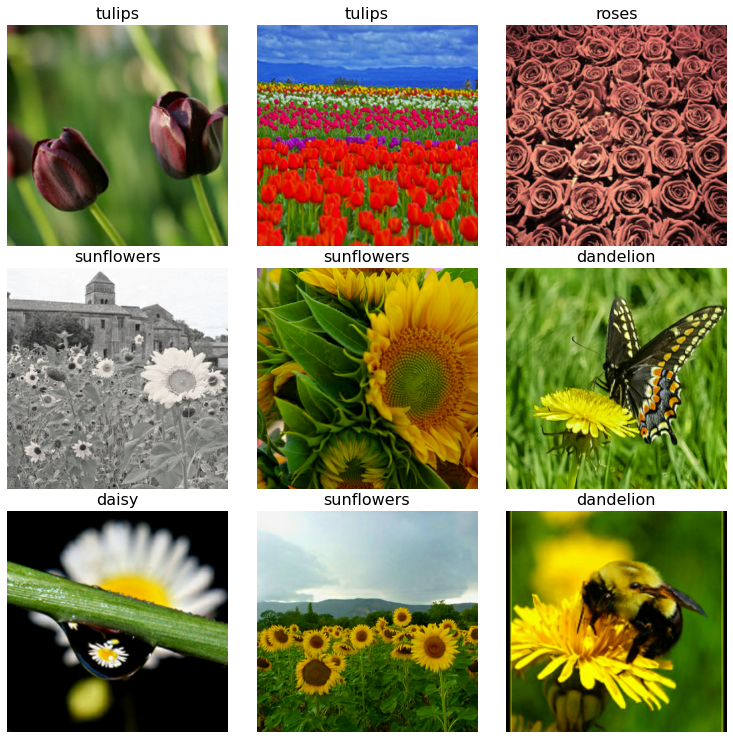

In [22]:
display_9_images_from_dataset(training_dataset)

## Load validation set images

In [23]:
validation_dataset = get_validation_dataset(
    val_split_files, dataset_config.image_size, train_config.batch_size
)
validation_dataset

<PrefetchDataset shapes: ((None, 331, 331, 3), (None, 5)), types: (tf.uint8, tf.float32)>

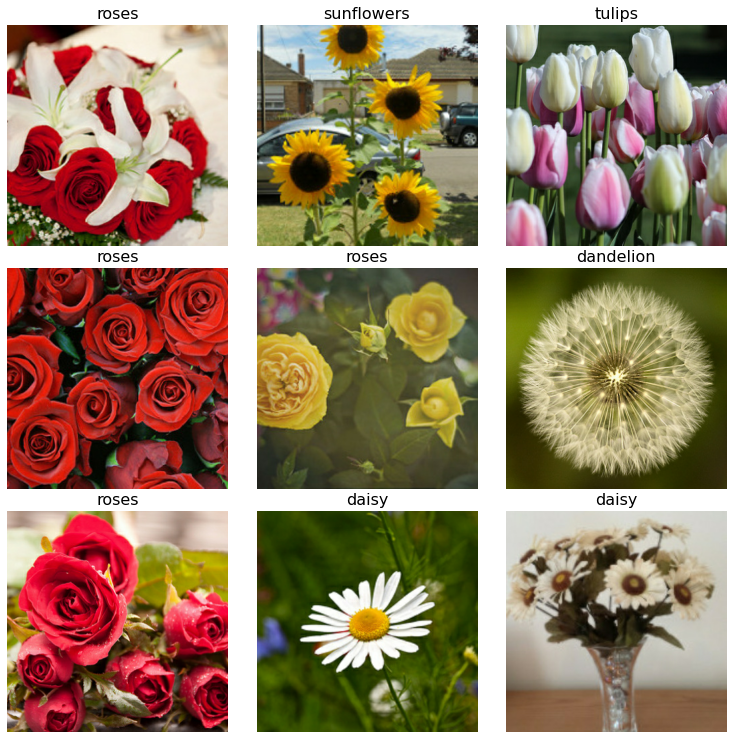

In [24]:
display_9_images_from_dataset(validation_dataset)

## Training

In [25]:
num_classes = len(dataset_config.classes)
with strategy.scope():
    model = create_xception_ft_model(dataset_config.image_size, num_classes)
model.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 331, 331, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


In [26]:
training_dataset = training_dataset.map(to_float32)
validation_dataset = validation_dataset.map(to_float32)

In [28]:
images_split_count_path = str(path/split_config.images_count_path)

with open(images_split_count_path, "r") as images_split_count_file:
    images_split_count = json.load(images_split_count_file)

num_training_images = images_split_count["num_training_images"]
num_validation_images = images_split_count["num_validation_images"]
num_training_images, num_validation_images

(2990, 680)

In [29]:
train_steps = num_training_images // train_config.batch_size
train_steps

23

In [30]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(lr_config, epoch), verbose=True)

In [31]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    steps_per_epoch=train_steps,
    epochs=train_config.epochs,
    callbacks=[lr_callback]
)

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
23/23 [==============================] - 59s 752ms/step - loss: 1.5929 - accuracy: 0.2438 - val_loss: 1.4066 - val_accuracy: 0.5191
Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
23/23 [==============================] - 6s 269ms/step - loss: 1.0428 - accuracy: 0.7157 - val_loss: 0.4032 - val_accuracy: 0.8794
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
23/23 [==============================] - 6s 274ms/step - loss: 0.3034 - accuracy: 0.9103 - val_loss: 0.1387 - val_accuracy: 0.9515
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
23/23 [==============================] - 6s 281ms/step - loss: 0.1401 - accuracy: 0.9551 - val_loss: 0.1368 - val_accuracy: 0.9529
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
23/23 [==============================] - 6s 272ms/step - loss: 0

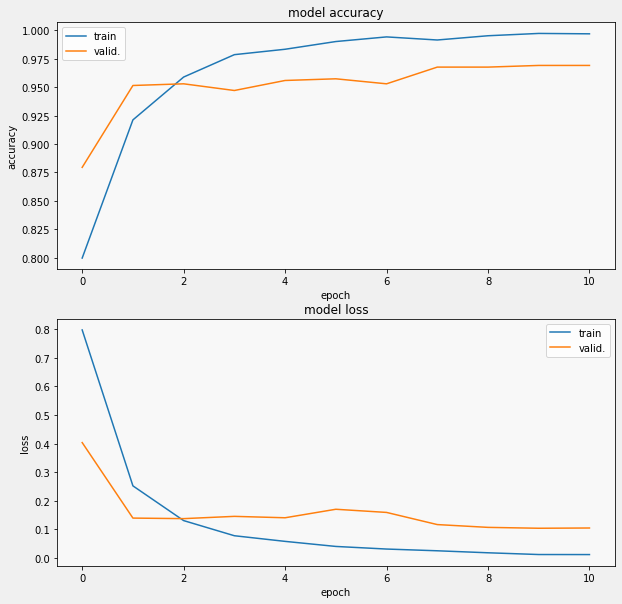

In [33]:
display_training_curves(
    history.history["accuracy"][1:],
    history.history["val_accuracy"][1:],
    "accuracy",
    211,
)
display_training_curves(
    history.history["loss"][1:], history.history["val_loss"][1:], "loss", 212
)

## Predictions

In [34]:
some_flowers, some_labels = dataset_to_numpy_util(validation_dataset, 160)

In [36]:
permutation = np.random.permutation(8 * 20)
some_flowers, some_labels = (
    some_flowers[permutation],
    some_labels[permutation],
)
predictions = model.predict(tf.cast(some_flowers, tf.float32), batch_size=16)
evaluations = model.evaluate(
    tf.cast(some_flowers, tf.float32), some_labels, batch_size=16
)

# print(
#    np.array(dataset_config.classes)[np.argmax(predictions, axis=-1)].tolist()
#)
print("[val_loss, val_acc]", evaluations)

10/10 [==============================] - 1s 26ms/step - loss: 0.1446 - accuracy: 0.9625
[val_loss, val_acc] [0.14460483193397522, 0.9625000357627869]


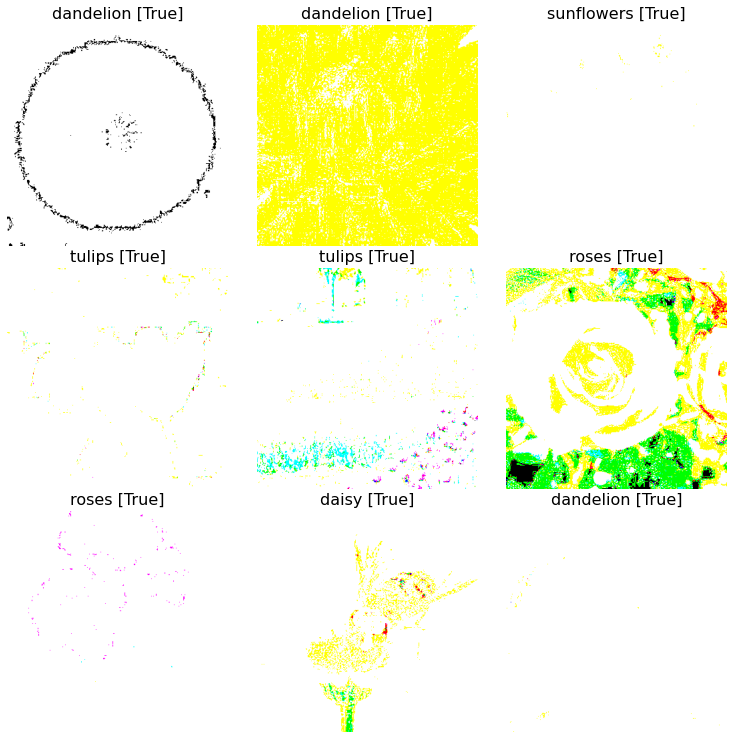

In [37]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

## Save model

In [38]:
model.save("model.h5")

## Use saved model for inference

10/10 [==============================] - 1s 27ms/step - loss: 0.1446 - accuracy: 0.9625


['dandelion', 'dandelion', 'sunflowers', 'tulips', 'tulips', 'roses', 'roses', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'tulips', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'roses', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'roses', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'roses', 'daisy', 'roses', 'sunflowers', 'tulips', 'sunflowers', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'roses', 'dandelion', 'tulips', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'roses', 'roses', 'sunflowers', 'daisy', 'tulips', 'roses', 'dandelion', 'daisy', 'tulips', 'dandelion', 'tulips', 'roses', 'roses', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'tulips', 'dandelion', 'dandelion', 'roses', 'tulips', 

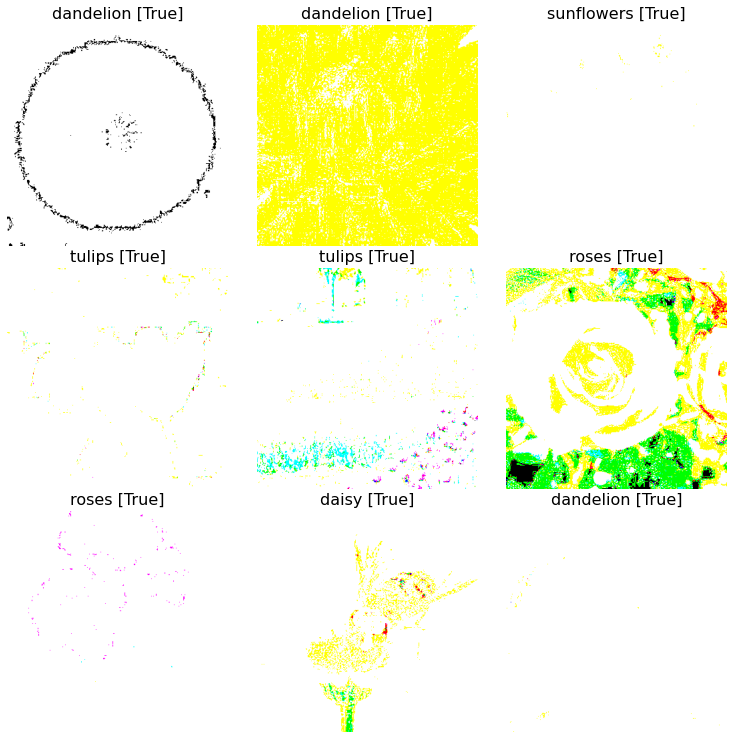

In [39]:
reload_model = tf.keras.models.load_model("model.h5")
predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
print(np.array(dataset_config.classes)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)
display_9_images_with_predictions(some_flowers, predictions, some_labels)

In [45]:
!dvc exp run --set-param train.epochs=20

Stage 'train' didn't change, skipping
ERROR: failed to reproduce 'dvc.yaml': Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started
ERROR: failed to reproduce 'dvc.yaml': Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started
